In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import xarray as xr

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from delhi_aq.jax.my_nn import SIREN, fit, NeRF, NeRFPE
from delhi_aq.jax.my_utils import pool_image, get_coords_for_image, rmse_fn

import matplotlib.pyplot as plt
from multiprocessing import Pool

In [5]:
seed = 0
config = {"lr": 1e-4, "batch_size": -1, "iterations": 10}
layers = [512]*4
activation_scale = 30.0
activation = "gelu"
aq_data = xr.open_dataset("../processed_data/delhi_cpcb_2022_cleaned.nc").to_dataframe().reset_index().set_index("time", drop=False)
aq_data['time'] = aq_data['time'].astype(int)
before = aq_data.shape[0]
aq_data = aq_data.dropna(subset=["PM2.5", "AT"])
after = aq_data.shape[0]
print(f"Removed {before-after} rows with NaNs % of total: {(before-after)/before*100:.2f}%")
aq_data.head(2)

Removed 95066 rows with NaNs % of total: 27.75%


,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:30:00,"Alipur, Delhi - DPCC",1640997000000000000,2022-01-01 00:00:00,2022-01-01 01:00:00,219.5,342.75,94.73,53.95,105.95,3.78,...,79.75,NaN,205.95,4.6,999.1,6.85,0.0,0.0,28.815329,77.15301
2022-01-01 01:30:00,"Alipur, Delhi - DPCC",1641000600000000000,2022-01-01 01:00:00,2022-01-01 02:00:00,224.5,360.25,89.30,44.70,96.60,5.50,...,82.23,NaN,206.05,4.6,998.9,6.72,0.0,0.0,28.815329,77.15301


In [6]:
all_stations = aq_data['station'].unique()

train_val_stations, test_stations = train_test_split(all_stations, test_size=1, random_state=seed+1)
train_stations, val_stations = train_test_split(train_val_stations, test_size=3, random_state=seed+2)

print("Test stations", test_stations)

train_df = aq_data[aq_data['station'].isin(train_stations)]
train_x_, train_y_ = train_df[['latitude', 'longitude', "time"]].values, train_df[['PM2.5', "AT"]].values
val_df = aq_data[aq_data['station'].isin(val_stations)]
val_x_, val_y_ = val_df[['latitude', 'longitude', "time"]].values, val_df[['PM2.5', "AT"]].values
test_df = aq_data[aq_data['station'].isin(test_stations)]
test_x_, test_y_ = test_df[['latitude', 'longitude', "time"]].values, test_df[['PM2.5', "AT"]].values

x_scaler = MinMaxScaler((-1, 1))
y_scaler = MinMaxScaler((0, 1))
time_scale = 20
train_x = x_scaler.fit_transform(train_x_)
train_x[:, -1] = train_x[:, -1] * time_scale
val_x = x_scaler.transform(val_x_)
val_x[:, -1] = val_x[:, -1] * time_scale
test_x = x_scaler.transform(test_x_)
test_x[:, -1] = test_x[:, -1] * time_scale
train_y = y_scaler.fit_transform(train_y_)
val_y = y_scaler.transform(val_y_)
test_y = y_scaler.transform(test_y_)
print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

Test stations ['Nehru Nagar, Delhi - DPCC']
(213473, 3) (25425, 3) (8573, 3) (213473, 2) (25425, 2) (8573, 2)


In [10]:
len(train_y)

213473

In [7]:
model = SIREN(n_hidden_layer_neurons=layers, output_shape=train_y_.shape[-1], activation_scale=activation_scale)
# model = NeRF(n_hidden_layer_neurons=layers, output_shape=train_y_.shape[-1], activation=activation)
# model = NeRFPE(n_hidden_layer_neurons=layers, output_shape=train_y_.shape[-1], activation=activation, activation_scale=activation_scale)

# extra processing
train_x_extra = np.concatenate([train_x, test_x])
train_y_extra = np.concatenate([train_y, test_y])
train_y_extra[len(train_y):, 0] = np.nan

params, old_params_history, train_losses, val_losses, test_losses = fit(jax.random.PRNGKey(seed+4), model, 
                                                                        train_x_extra, train_y_extra, config, val_x, val_y, test_x, test_y)

In [12]:
params

FrozenDict({
    params: {
        Dense_0: {
            bias: Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, 

In [8]:
# plt.plot(train_losses, label="train")
# plt.plot(val_losses, label="val")
# plt.plot(test_losses, label="test")
# plt.legend();
best_val_idx = jnp.argmin(val_losses)
print(f"{best_val_idx=}, {val_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=}")
print(f"{train_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=}")
print(f"{test_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=}")
best_params = jtu.tree_map(lambda x: x[best_val_idx], old_params_history)

pred_y = model.apply(best_params, test_x).__array__()
pred_y_ = y_scaler.inverse_transform(pred_y)
# plt.scatter(test_y_, pred_y_)
# plt.plot([0, 500], [0, 500], color="r", linestyle="--");

print(pred_y_.shape, test_y_.shape)
rmse = mean_squared_error(test_y_, pred_y_, squared=False, multioutput="raw_values")
rmse

best_val_idx=Array(1, dtype=int32), val_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=Array([0., 0.], dtype=float32)
train_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=Array([0., 0.], dtype=float32)
test_losses[best_val_idx]*(y_scaler.data_max_ - y_scaler.data_min_)=Array([0., 0.], dtype=float32)
(8573, 2) (8573, 2)


ValueError: Input contains NaN.

In [28]:
len(val_stations), len(train_stations)

(3, 26)

0.02921045

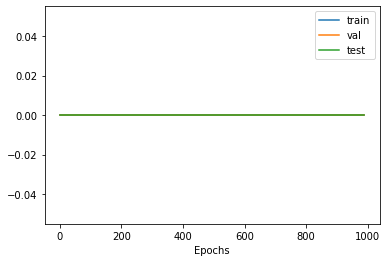

In [6]:
offset = 10
plt.plot(train_losses[offset:], label="train")
plt.plot(val_losses[offset:], label="val")
plt.plot(test_losses[offset:], label="test")
plt.xlabel("Epochs")
plt.legend();

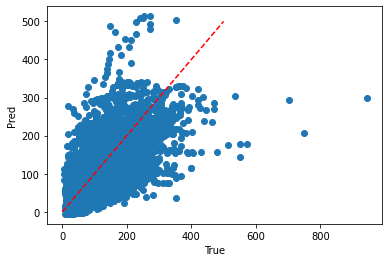

In [79]:
plt.scatter(test_y_, pred_y_);
plt.plot([0, 500], [0, 500], color="r", linestyle="--");
plt.xlabel("True")
plt.ylabel("Pred");

In [80]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
model.fit(train_x_, train_y_.ravel())
print("Train RMSE", rmse_fn(train_y_, model.predict(train_x_)))
print("Val RMSE", rmse_fn(val_y_, model.predict(val_x_)))
print("Test RMSE", rmse_fn(test_y_, model.predict(test_x_)))

Train RMSE 9.659245038620865
Val RMSE 48.49124286275065
Test RMSE 54.727142049642694


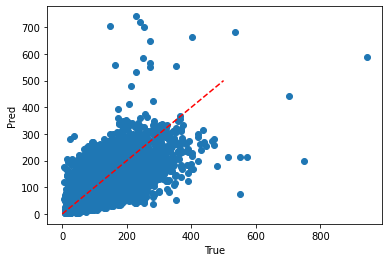

In [81]:
plt.scatter(test_y_, model.predict(test_x_));
plt.plot([0, 500], [0, 500], color="r", linestyle="--");
plt.xlabel("True")
plt.ylabel("Pred");

## Manual plot

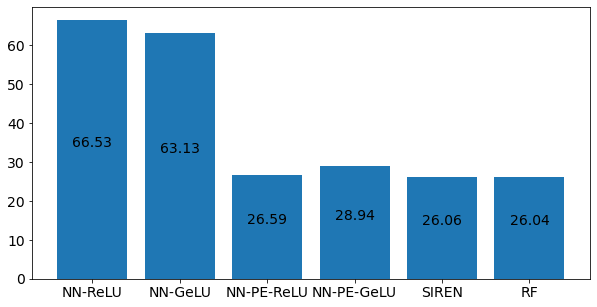

In [8]:
results = {"NN-ReLU": 66.53, "NN-GeLU": 63.13, "NN-PE-ReLU": 26.59, "NN-PE-GeLU": 28.94, "SIREN": 26.06, "RF": 26.04}

plt.figure(figsize=(10, 5))
plt.rcParams["font.size"] = 14
plt.bar(results.keys(), results.values());
for k, v in results.items():
    plt.text(k, v/2, f"{v:.2f}", ha="center", va="bottom")

In [97]:
def fn(p):
    a = p - jnp.array([1, 2, 3.0, jnp.nan])
    return jnp.where(jnp.isnan(a), 0, a)

jax.jacobian(fn)(10.0), fn(10)

(Array([1., 1., 1., 0.], dtype=float32, weak_type=True),
 Array([9., 8., 7., 0.], dtype=float32))